In [1]:
import numpy as np
import pandas as pd
import pickle
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


In [2]:
def extract_year(desc):
    """
    Parses a description string and extracts a numerical year from it. 
    Matches a 4-digit number between 1850 and 2023. FYI the first ever baseball card was made in 1856
    Args:
        desc (str): description
    Returns:
        year (num): the year
    """
    pattern = r'(\b\d{4}\b)'
    matches = re.findall(pattern, desc)  # within a given description, find all instances of the conditions
    for match in matches:
        year = int(match)
        if year >= 1850 and year <= 2023:  # grab the first instance that makes chronological sense
            return year
    return float('nan')

In [3]:
## LOAD THE METADATA ##

# combine all of the metadata files
df1 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA1_collectors_metadata.pkl')
df2 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA2_collectors_metadata.pkl')
df3 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA3_collectors_metadata.pkl')
df4 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA4_collectors_metadata.pkl')
df5 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA5_collectors_metadata.pkl')
df6 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA6_collectors_metadata.pkl')
df7 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA7_collectors_metadata.pkl')
df8 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA8_collectors_metadata.pkl')
df9 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA9_collectors_metadata.pkl')
df10 = pd.read_pickle('/Users/brianmiller/Desktop/collection_files/PSA10_collectors_metadata.pkl')

# concatenate dataframes
metadata_df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10])


In [4]:
## PREPROCESSING STEPS ##

# get the grade int from the grade string
metadata_df['grade_num'] = metadata_df['grade'].str.extract(r'(\d{1,2})')  # captures 1 or 2 digits in a capturing group
metadata_df['grade_num'] = pd.to_numeric(metadata_df['grade_num'])

# get the price num from the price string
# captures the digits (with optional comma for thousand separators) and decimal point (with 2 decimal places) in a capturing group
metadata_df['price_num'] = metadata_df['price'].str.extract(r'\$([\d,]+(?:\.\d{2})?)')
metadata_df['price_num'] = pd.to_numeric(metadata_df['price_num'].str.replace(',', ''))

# get the year from the description string
metadata_df['year'] = metadata_df['desc'].apply(extract_year)

# shorten the file name to just the file, not the full path
# The ([^/]+) group captures the filename (and extension) at the end of the path
metadata_df["image_name_file"] = metadata_df["image_name"].str.extract(r"/([^/]+)$")

# clean up the source column
# matches any string of characters enclosed in parentheses, along with any whitespace before or after the parentheses
# It then applies this pattern to each string in the 'source' column using the re.sub() function, which removes all occurrence
metadata_df['source_clean'] = metadata_df['source'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))

print(metadata_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366239 entries, 1 to 104041
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               366239 non-null  int64  
 1   grade            366239 non-null  object 
 2   image_name       366239 non-null  object 
 3   price            357581 non-null  object 
 4   desc             366239 non-null  object 
 5   source           366239 non-null  object 
 6   grade_num        366239 non-null  int64  
 7   price_num        357581 non-null  float64
 8   year             362895 non-null  float64
 9   image_name_file  366239 non-null  object 
 10  source_clean     366239 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 33.5+ MB
None


In [5]:
## MAKE A TRUNCATED VERSION OF THE METADATA ##

# subset the metadata to just the files in a specific folder
folder_path = "/Users/brianmiller/Desktop/collection_files/images_3k"
file_names = os.listdir(folder_path)  # get file names
metadata_df_subset = metadata_df[metadata_df["image_name_file"].isin(file_names)]

# print(metadata_df_subset.info())
print(metadata_df_subset[["grade_num"]].value_counts())

# # save to pickle file
# metadata_df_subset.to_pickle("metadata_3k_subset.pickle")



grade_num
10           3000
9            2999
1            2971
2            2938
8            2937
4            2928
3            2908
5            2906
6            2905
7            2876
dtype: int64


In [6]:
##  GET SIZE METADATA ABOUT THE IMAGES  ##

# Define empty lists for the dimensions and resolution
widths = []
heights = []
resolutions = []

files_rotated = 0

# Loop through the filenames in the dataframe
for filename in metadata_df_subset['image_name']:
    
    # Open the image using Pillow
    image = Image.open(filename)
    
    # Get the dimensions and resolution
    width, height = image.size
    resolution = image.info.get('dpi', None)
    
    # if the image is on its side, then rotate the image
    if width > height:
        files_rotated +=1  # add to counter
        rotated_image = image.rotate(90)  # rotate the image by 90 degrees clockwise
        rotated_image.save(filename)  # save the rotated image
    
    # Add the values to the lists
    widths.append(width)
    heights.append(height)
    resolutions.append(resolution)
    
    # Close the image file
    image.close()

# Add the lists to the dataframe as new columns
metadata_df_subset['width'] = widths
metadata_df_subset['height'] = heights
metadata_df_subset['resolution'] = resolutions

print("Files Rotated {}".format(files_rotated))
print(metadata_df_subset.info())
metadata_df = metadata_df_subset


Files Rotated
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29368 entries, 1 to 3000
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               29368 non-null  int64  
 1   grade            29368 non-null  object 
 2   image_name       29368 non-null  object 
 3   price            28416 non-null  object 
 4   desc             29368 non-null  object 
 5   source           29368 non-null  object 
 6   grade_num        29368 non-null  int64  
 7   price_num        28416 non-null  float64
 8   year             28954 non-null  float64
 9   image_name_file  29368 non-null  object 
 10  source_clean     29368 non-null  object 
 11  width            29368 non-null  int64  
 12  height           29368 non-null  int64  
 13  resolution       29342 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 3.4+ MB
None


/var/folders/8c/kzx234q16zdf6dwkcnk692x80000gn/T/ipykernel_93906/2978719502.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_subset['width'] = widths
/var/folders/8c/kzx234q16zdf6dwkcnk692x80000gn/T/ipykernel_93906/2978719502.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_subset['height'] = heights
/var/folders/8c/kzx234q16zdf6dwkcnk692x80000gn/T/ipykernel_93906/2978719502.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

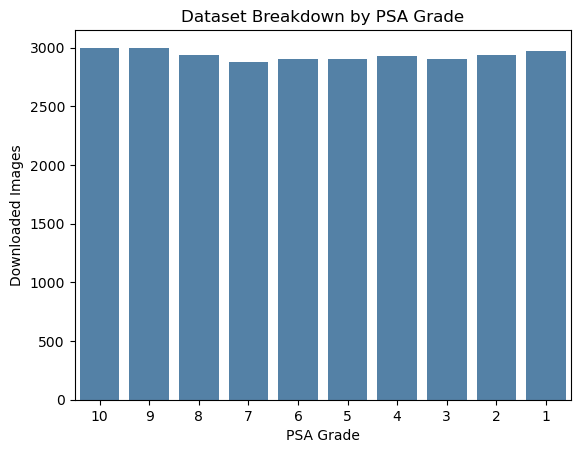

In [7]:
##  VISUALIZE DISTRIBUTION  ##

sns.countplot(x='grade_num', data=metadata_df,color='steelblue', order=sorted(metadata_df['grade_num'].unique(), reverse=True))

# Set the plot title and axis labels
plt.title('Dataset Breakdown by PSA Grade')
plt.xlabel('PSA Grade')
plt.ylabel('Downloaded Images')

# Display the plot
plt.show()




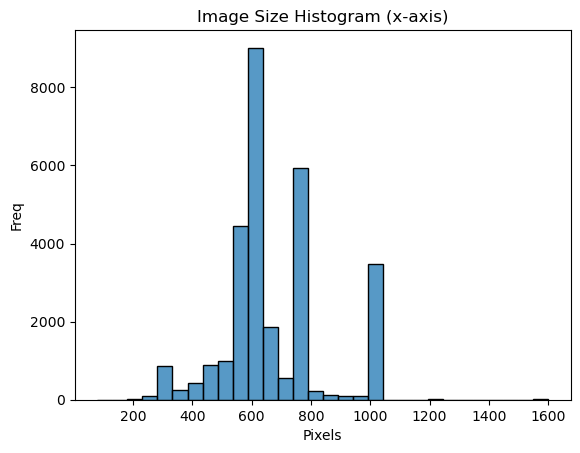

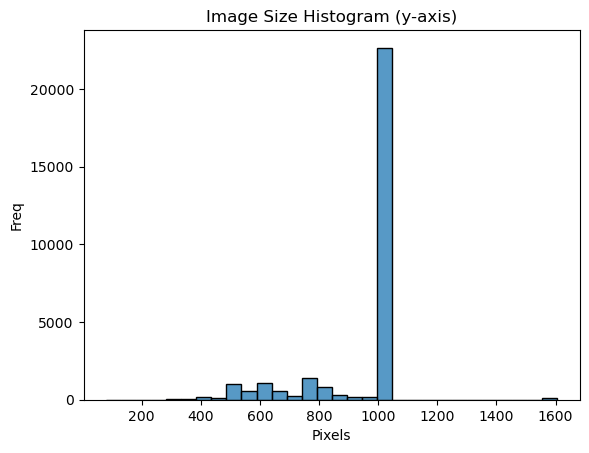

In [8]:
## IMAGE DIMENSIONS DISTRIBUTIONS
sns.histplot(metadata_df['width'], kde=False, bins=30)
plt.title('Image Size Histogram (x-axis)')
plt.xlabel('Pixels')
plt.ylabel('Freq')
plt.show()

sns.histplot(metadata_df['height'], kde=False, bins=30)
plt.title('Image Size Histogram (y-axis)')
plt.xlabel('Pixels')
plt.ylabel('Freq')
plt.show()

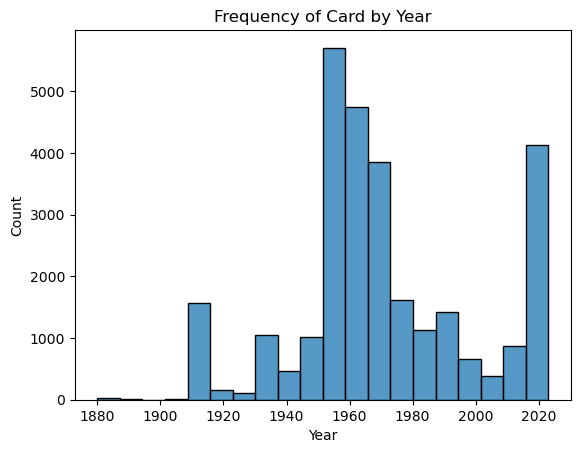

In [9]:
sns.histplot(metadata_df['year'], kde=False, bins=20)
plt.title('Frequency of Card by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

/var/folders/8c/kzx234q16zdf6dwkcnk692x80000gn/T/ipykernel_93906/4143023990.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  source_counts = source_counts[top_4_sources].append(pd.Series([source_counts[top_4_sources[4:]].sum()], index=['others']))


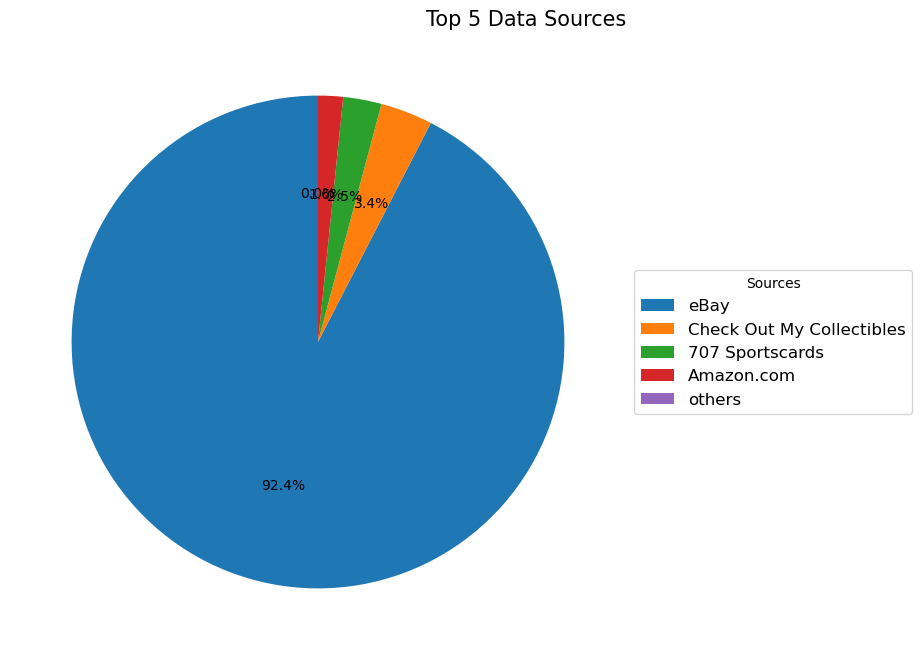

In [10]:
# Compute the top 5 most frequent unique values and group the rest as 'others'
source_counts = metadata_df['source_clean'].value_counts()
top_4_sources = source_counts.index[:4]
source_counts = source_counts[top_4_sources].append(pd.Series([source_counts[top_4_sources[4:]].sum()], index=['others']))

# Create the pie chart with the modified value counts and a legend
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(source_counts, labels=None, autopct='%1.1f%%', startangle=90)
plt.legend(source_counts.index, title='Sources', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Set the title and adjust the font size
plt.title('Top 5 Data Sources', fontsize=15, loc='right')
plt.show()


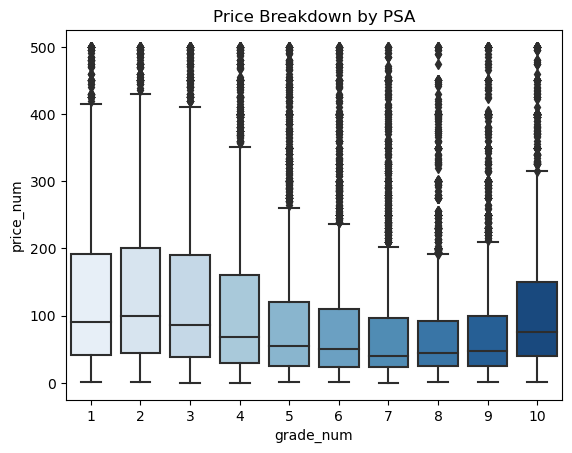

In [11]:
sns.boxplot(x='grade_num', y='price_num', data= metadata_df[metadata_df['price_num'] < 500], palette='Blues')
plt.title('Price Breakdown by PSA', fontsize=12, loc='center')
plt.show()

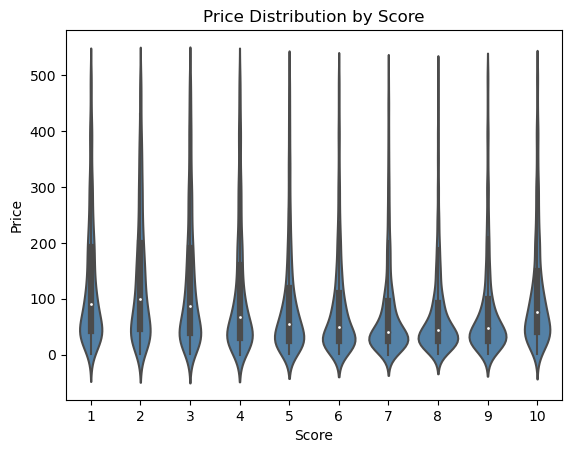

In [12]:

# create violin plot
sns.violinplot(x='grade_num', y='price_num', data=metadata_df[metadata_df['price_num'] < 500], color='steelblue')

# set x and y labels and title
plt.xlabel('Score')
plt.ylabel('Price')
plt.title('Price Distribution by Score')

# show plot
plt.show()

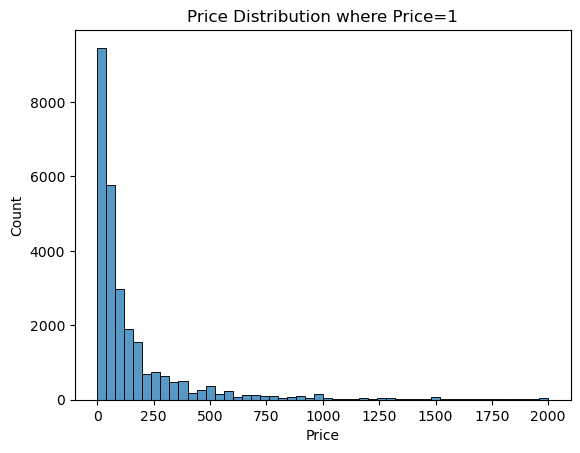

In [13]:
df_subset = metadata_df[metadata_df['grade_num'] == 8]
df_subset = metadata_df[metadata_df['price_num'] < 2000]

# create histogram
sns.histplot(data=df_subset, x='price_num', bins=50)

# set x and y labels and title
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Distribution where Price=1')

# show plot
plt.show()